# 1 Import bibliotecas

In [94]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 2 Parâmetros de simulação e niveis de estoque
- Assumindo um conhecimento prévio sobre a distribuição da demanda (normal)

In [99]:
# Num simulações
num_simulacoes = 400

In [100]:
# Qtd de dias por simulação (6 meses)
n_dias = 180

In [101]:
media_demanda = 30  # Demanda diaria
desvio_padrao_demanda = 2 # Desv pad diario


In [98]:
## Niveis de estoque atual
estoque_inicial = 1500 

# 3 Regras de negócio

## 3.1 Lead time fornecedor
- Assumindo um conhecimento prévio sobre a distribuição do lead time do fornecedor
- Os fornecedores geralmente trabalham com tempo min, max e o mais provável
- Assumiremos distribuição triangula, portanto!

In [33]:
tempo_reposicao_min = 4 
tempo_reposicao_max = 14
tempo_reposicao_most_likely = 10

## 3.2 Estoque mínimo
- Estoque mínimo é aquele que quando atingido deve ser efetuado uma compra imediatamente!

- O estoque mínimo, como regra de negócio dessa empresa é definido como a quantidade a ser mantida no estoque para lidar com possíveis faltas desse produto no fornecedor
- Deve ser levado em considerado o lead time máximo do fornecedor, dess forma definiremos como a quantidade para suprir 2* o leadtime máximo do fornecedor.

In [34]:
estoque_minimo = media_demanda * (tempo_reposicao_max * 2)
estoque_minimo

840

## 3.3 A quantidade reabastecida (negociada no ato da compra)
- Política de abastecimento: Na data de chegada do pedido o estoque tem que ser suficiente para abastecer +2 meses + lead time fornecedor máximo antes de atingir o nível de estoque minimo novamente


In [103]:
n_dias_reabast = 60
qtd_comprada_dia = media_demanda * (n_dias_reabast + tempo_reposicao_max)

# 4 Simulação de Monte Carlo

In [104]:
# Resultado da simulação
df_resultados = pd.DataFrame(columns = ['n_simulacao', 'n_dia','estoque_dia','demanda_dia', 'flag_reabasteceu', 'qtd_reabastecida_dia', 'flag_comprou', 'qtd_comprada_dia','lead_time_forn_dia','n_dia_chegada', 'flag_houve_stockout'])

# Roda varias simulações
for n_sim in range(num_simulacoes):

    # Simula a demanda para os próximos n_dias (normal)
    demandas = np.random.normal(media_demanda, desvio_padrao_demanda, n_dias)
    demandas = demandas.astype(int)  # Convertendo para inteiros

    ## Inicializa o estoque para os niveis atuais no começo da simulação
    estoque = estoque_inicial

    ## Inicializa o dataframe de compras em aberto
    df_compras = pd.DataFrame(columns=['qtd','leadtime','n_dia','n_dia_chegada'])
    

    # Percorre cada dia de simulação
    for dia in range(n_dias):

        ## Iniciando o dia da simulação sem reabastecimento e sem compra ainda sem stockout
        flag_reabasteceu = 0
        flag_comprou = 0
        qtd_comprada_dia = np.nan
        tempo_reposicao_dia = np.nan
        n_dia_chegada = np.nan
        qtd_reabastecida = np.nan
        flag_houve_stockout = 0

        ########## Efetua Reposição de produtos no dia da simulação
        if dia in df_compras.n_dia_chegada.unique().tolist():
            qtd_reabastecida = df_compras[df_compras['n_dia_chegada']==dia].qtd.sum()
            estoque = estoque + qtd_reabastecida

            ## Atualiza o dataframe de compras em aberto
            df_compras = df_compras[df_compras['n_dia_chegada']!=dia]

            ## Atualiza flag reabastecimento
            flag_reabasteceu = 1

        # Reduz o estoque baseado na demanda
        estoque = estoque - demandas[dia]

        ## Corrige o estoque para 0 pois nao pode ser negativo
        if estoque < 0:
            estoque = 0
 

        ########## Verifica condição de stockout
        if estoque == 0:
            flag_houve_stockout = 1

        ########## Efetua compra no dia da simulação
        # Inicializa variavel de decisão de compra
        comprar = False
        qtd_comprada_dia = 0
        
        # Caso estoque atinja o estoque mínimo inicializa checagens para decisão de compra
        if estoque < estoque_minimo:

            ## Caso ja tenha compras em aberto então checar outras condições (se a compra será suficiente por ex)
            if len(df_compras) > 0:

                ## Checa se o pedido de compra em aberto será suficiente para superar o estoque mínimo na data prevista da entrega
                ## Caso haja multiplas compras checa a qtd total comprada e o nível de estoque na data prevista de entrega mais distante
                qtd_comprada_historico = df_compras.qtd.sum()
                n_dia_chegada = df_compras.n_dia_chegada.max()
                estimativa_estoque_data_entrega_max = estoque - media_demanda * (n_dia_chegada - dia) + qtd_comprada_historico

                ## Caso as compras não tenham sido suficientes para superar o estoque mínimo então efetuar nova compra
                if estimativa_estoque_data_entrega_max < estoque_minimo:
                
                    comprar = True
                    flag_comprou = 1

                else:
                    comprar = False

            ## Caso nao tenha compras em aberto então é necessário comprar!!        
            else:
                comprar = True
                flag_comprou = 1


            ## Efetua a compra
            if comprar == True:
                
                # Simula o lead time com distribuição triangular
                tempo_reposicao_dia = np.random.triangular(
                    tempo_reposicao_min,
                    tempo_reposicao_most_likely,
                    tempo_reposicao_max)
                
                tempo_reposicao_dia = int(tempo_reposicao_dia) ## em dias inteiros

                n_dia_chegada = dia + tempo_reposicao_dia ## Calcula qtd de dias até a reposição
                
                
                # O pedido é efetuado:
                ## na data de chegada do pedido o estoque tem que ser suficiente para abastecer +2 meses antes de atingir o estoque minimo novamente
                ## qtd_comprada_dia

                ## Armazena os dados de compra
                df_compra_dia = pd.DataFrame(np.array([[qtd_comprada_dia,tempo_reposicao_dia,dia,n_dia_chegada ]]), columns=['qtd','leadtime','n_dia','n_dia_chegada'])
                df_compras = pd.concat([df_compras, df_compra_dia], ignore_index=True)
        

        # Armazena os resultados da simulação diaria por n_sim
        df_resultados_dia = pd.DataFrame(np.array([[n_sim, dia, estoque, demandas[dia], flag_reabasteceu, qtd_reabastecida, flag_comprou, qtd_comprada_dia, tempo_reposicao_dia, n_dia_chegada, flag_houve_stockout ]]), 
                                         columns = ['n_simulacao', 'n_dia','estoque_dia', 'demanda_dia', 'flag_reabasteceu', 'qtd_reabastecida_dia', 'flag_comprou', 'qtd_comprada_dia','lead_time_forn_dia','n_dia_chegada', 'flag_houve_stockout'])
        df_resultados = pd.concat([df_resultados, df_resultados_dia], ignore_index=True)

        print(f'simulacao = {n_sim} - dia = {dia} - estoque = {estoque}')

C:\Users\pichau\AppData\Local\Temp\ipykernel_848\3993582341.py:111: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_resultados = pd.concat([df_resultados, df_resultados_dia], ignore_index=True)


simulacao = 0 - dia = 0 - estoque = 1473
simulacao = 0 - dia = 1 - estoque = 1444
simulacao = 0 - dia = 2 - estoque = 1416
simulacao = 0 - dia = 3 - estoque = 1386
simulacao = 0 - dia = 4 - estoque = 1358
simulacao = 0 - dia = 5 - estoque = 1329
simulacao = 0 - dia = 6 - estoque = 1296
simulacao = 0 - dia = 7 - estoque = 1264
simulacao = 0 - dia = 8 - estoque = 1238
simulacao = 0 - dia = 9 - estoque = 1211
simulacao = 0 - dia = 10 - estoque = 1182
simulacao = 0 - dia = 11 - estoque = 1155
simulacao = 0 - dia = 12 - estoque = 1123
simulacao = 0 - dia = 13 - estoque = 1090
simulacao = 0 - dia = 14 - estoque = 1061
simulacao = 0 - dia = 15 - estoque = 1029
simulacao = 0 - dia = 16 - estoque = 1001
simulacao = 0 - dia = 17 - estoque = 972
simulacao = 0 - dia = 18 - estoque = 948
simulacao = 0 - dia = 19 - estoque = 919
simulacao = 0 - dia = 20 - estoque = 888
simulacao = 0 - dia = 21 - estoque = 858
simulacao = 0 - dia = 22 - estoque = 832
simulacao = 0 - dia = 23 - estoque = 804
simulacao

In [109]:
## conta qts stockout teve e por qts dias vc ficou sem atender a demanda diaria e quanto isso representa em perdas...
## Problema: tenho que aumentar meu capital de giro reduzindo o estoque, comprar menos e aumentar a qtd de pedidos,
## até quanto eu consigo flexibilizar essa politica de compra sem causar stockouts 
## e caso haja stockout qual é o tradeoff da "capital de giro" vs qtd dinheiro perdido por stockout.

In [89]:
df_resultados

,n_simulacao,n_dia,estoque_dia,demanda_dia,flag_reabasteceu,qtd_reabastecida_dia,flag_comprou,qtd_comprada_dia,lead_time_forn_dia,n_dia_chegada,flag_houve_stockout
0,0.0,0.0,1472.0,28.0,0.0,NaN,0.0,0.0,NaN,NaN,0.0
1,0.0,1.0,1442.0,30.0,0.0,NaN,0.0,0.0,NaN,NaN,0.0
2,0.0,2.0,1415.0,27.0,0.0,NaN,0.0,0.0,NaN,NaN,0.0
3,0.0,3.0,1384.0,31.0,0.0,NaN,0.0,0.0,NaN,NaN,0.0
4,0.0,4.0,1352.0,32.0,0.0,NaN,0.0,0.0,NaN,NaN,0.0
...,...,...,...,...,...,...,...,...,...,...,...
175,0.0,175.0,764.0,29.0,0.0,NaN,0.0,0.0,NaN,182.0,0.0
176,0.0,176.0,732.0,32.0,0.0,NaN,0.0,0.0,NaN,182.0,0.0
177,0.0,177.0,698.0,34.0,0.0,NaN,0.0,0.0,NaN,182.0,0.0
178,0.0,178.0,672.0,26.0,0.0,NaN,0.0,0.0,NaN,182.0,0.0


In [90]:
df_resultados[df_resultados['flag_houve_stockout']==1]

,n_simulacao,n_dia,estoque_dia,demanda_dia,flag_reabasteceu,qtd_reabastecida_dia,flag_comprou,qtd_comprada_dia,lead_time_forn_dia,n_dia_chegada,flag_houve_stockout


In [91]:
df_resultados[df_resultados['flag_reabasteceu']==1]

,n_simulacao,n_dia,estoque_dia,demanda_dia,flag_reabasteceu,qtd_reabastecida_dia,flag_comprou,qtd_comprada_dia,lead_time_forn_dia,n_dia_chegada,flag_houve_stockout
31,0.0,31.0,2784.0,26.0,1.0,2220.0,0.0,0.0,NaN,NaN,0.0
103,0.0,103.0,2866.0,26.0,1.0,2220.0,0.0,0.0,NaN,NaN,0.0


In [92]:
df_resultados[df_resultados['flag_comprou']==1]

,n_simulacao,n_dia,estoque_dia,demanda_dia,flag_reabasteceu,qtd_reabastecida_dia,flag_comprou,qtd_comprada_dia,lead_time_forn_dia,n_dia_chegada,flag_houve_stockout
22,0.0,22.0,827.0,29.0,0.0,NaN,1.0,2220.0,9.0,31.0,0.0
97,0.0,97.0,820.0,29.0,0.0,NaN,1.0,2220.0,6.0,103.0,0.0
173,0.0,173.0,821.0,27.0,0.0,NaN,1.0,2220.0,9.0,182.0,0.0


In [93]:
df_compras

,qtd,leadtime,n_dia,n_dia_chegada
0,2220,9,173,182


Probabilidade de Stockout: 1.0
Estoque Médio ao Final do Período: -128.644
Desvio Padrão do Estoque ao Final do Período: 88.81898031389463


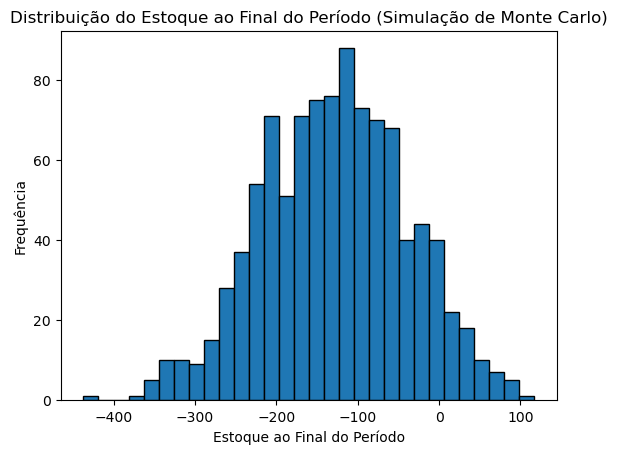

In [7]:
# Análise dos resultados
probabilidade_stockout = sum(resultados_stockout) / num_simulacoes
media_estoque_final = np.mean(resultados_estoque_final)
desvio_padrao_estoque_final = np.std(resultados_estoque_final)

# Exibir resultados
print("Probabilidade de Stockout:", probabilidade_stockout)
print("Estoque Médio ao Final do Período:", media_estoque_final)
print("Desvio Padrão do Estoque ao Final do Período:", desvio_padrao_estoque_final)

# Visualizar a distribuição do estoque final
plt.hist(resultados_estoque_final, bins=30, edgecolor='black')
plt.xlabel("Estoque ao Final do Período")
plt.ylabel("Frequência")
plt.title("Distribuição do Estoque ao Final do Período (Simulação de Monte Carlo)")
plt.show()

In [70]:
import numpy as np
import matplotlib.pyplot as plt

# Número de simulações
num_simulacoes = 1000

# Parâmetros da simulação
media_demanda = 100  # Demanda média diária
desvio_padrao_demanda = 20  # Desvio padrão da demanda
estoque_inicial = 300  # Estoque inicial
estoque_minimo = 50  # Limite mínimo para reabastecimento
quantidade_reabastecimento = 200  # Quantidade a ser reabastecida
tempo_reposicao_min = 2 

Probabilidade de Stockout: 1.0
Estoque Médio ao Final do Período: -131.678
Desvio Padrão do Estoque ao Final do Período: 93.17622183797752


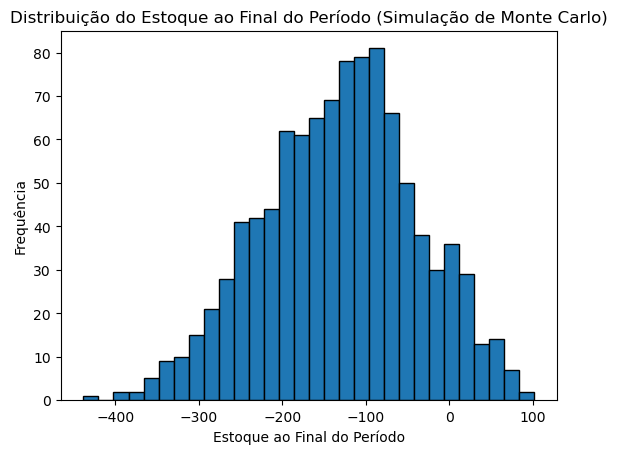

In [71]:
# Tempo mínimo para reposição
tempo_reposicao_max = 5  # Tempo máximo para reposição
tempo_reposicao_most_likely = 3  # Tempo mais provável para reposição

# Resultado da simulação
resultados_stockout = []  # Quantidade de vezes que houve stockout
resultados_estoque_final = []  # Estoque ao final do período de simulação

# Simulação de Monte Carlo
for i in range(num_simulacoes):
    # Simular a demanda para 30 dias
    demandas = np.random.normal(media_demanda, desvio_padrao_demanda, 30)
    demandas = demandas.astype(int)  # Convertendo para inteiros
    estoque = estoque_inicial
    houve_stockout = False
    
    # Simular o processo de gerenciamento de estoques
    for dia in range(30):
        # Reduzir o estoque com base na demanda diária
        estoque -= demandas[dia]
        
        # Verificar se houve stockout
        if estoque < 0:
            houve_stockout = True
        
        # Se o estoque cair abaixo do mínimo, iniciar o processo de reposição
        if estoque < estoque_minimo:
            # Tempo de reposição com distribuição triangular
            tempo_reposicao = np.random.triangular(
                tempo_reposicao_min,
                tempo_reposicao_most_likely,
                tempo_reposicao_max,
            )
            # Reabastecer após o tempo de reposição
            if dia + tempo_reposicao < 30:
                estoque += quantidade_reabastecimento
        
    # Armazenar os resultados
    resultados_stockout.append(houve_stockout)
    resultados_estoque_final.append(estoque)

# Análise dos resultados
probabilidade_stockout = sum(resultados_stockout) / num_simulacoes
media_estoque_final = np.mean(resultados_estoque_final)
desvio_padrao_estoque_final = np.std(resultados_estoque_final)

# Exibir resultados
print("Probabilidade de Stockout:", probabilidade_stockout)
print("Estoque Médio ao Final do Período:", media_estoque_final)
print("Desvio Padrão do Estoque ao Final do Período:", desvio_padrao_estoque_final)

# Visualizar a distribuição do estoque final
plt.hist(resultados_estoque_final, bins=30, edgecolor='black')
plt.xlabel("Estoque ao Final do Período")
plt.ylabel("Frequência")
plt.title("Distribuição do Estoque ao Final do Período (Simulação de Monte Carlo)")
plt.show()

In [27]:
!pip install simpy

In [73]:
len(resultados_estoque_final)

1000